# Imports

In [19]:
from IPython.display import display
import numpy as np
from sklearn.linear_model import LinearRegression

import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Dataset, TensorDataset, DataLoader
from torch.utils.data.dataset import random_split
from torch.utils.tensorboard import SummaryWriter

import matplotlib.pyplot as plt
%matplotlib inline
%load_ext tensorboard
# %tensorboard --logdir runs

plt.style.use('fivethirtyeight')

def make_train_step_fn(model, loss_fn, optimizer):
    def train_step_fn(x, y):
        # set model to train mode
        model.train()
        # forward pass
        yhat = model(x)
        # compute loss
        loss = loss_fn(yhat, y)
        # update parameters
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        # return loss
        return loss.item()
    return train_step_fn

def make_validation_step_fn(model, loss_fn):
    def validation_step_fn(x, y):
        # set model to eval
        model.eval()

        # forward pass
        yhat = model(x)
        # loss computation
        loss = loss_fn(yhat, y)
        return loss.item()
    return validation_step_fn

def mini_batch(device, data_loader, step_fn):
    mini_batch_losses = []
    for x_batch, y_batch in data_loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        loss = step_fn(x_batch, y_batch)
        mini_batch_losses.append(loss)
    loss = np.mean(mini_batch_losses)
    return loss

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


# Data Preparation

In [20]:
%%writefile data/v2.py

device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
display(device)

RANDOM_SEED = 13
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

# Syntetic Data Generation
true_b = 1
true_w = 2
N = 200

x = np.random.rand(N, 1)
epsilon = (0.1 * np.random.randn(N, 1))
y = true_b + true_w * x + epsilon

x_tensor = torch.as_tensor(x).float()
y_tensor = torch.as_tensor(y).float()
# All data points
dataset = TensorDataset(x_tensor, y_tensor)

# Generates train and validation sets
ratio = 0.8
n_total = len(dataset)
n_train = int(n_total * ratio)
n_validation = n_total - n_train
train_data, validation_data = random_split(dataset, [n_train, n_validation])
display(train_data[:5])

# Data Loaders
train_loader = DataLoader(dataset=train_data, batch_size=16, shuffle=True)
validation_loader = DataLoader(dataset=validation_data, batch_size=16)

# Extract train and validation data
x_train, y_train = zip(*[(x, y) for x, y in train_data])
x_val, y_val = zip(*[(x, y) for x, y in validation_data])

# Convert to numpy arrays for plotting
x_train = np.array(x_train)
y_train = np.array(y_train)
x_val = np.array(x_val)
y_val = np.array(y_val)

# Plotting
plt.scatter(x_train, y_train, color='blue', s=5, label='Train Data')
plt.scatter(x_val, y_val, color='red', s=5, label='Validation Data')
plt.legend()
plt.title('Training and Validation Data')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

x_train_tensor = torch.as_tensor(x_train, dtype=torch.float32, device=device)
y_train_tensor = torch.as_tensor(y_train, dtype=torch.float32, device=device)

Overwriting data/v2.py


device(type='mps')

(tensor([[0.0094],
         [0.0679],
         [0.8166],
         [0.9133],
         [0.6889]]),
 tensor([[0.9134],
         [1.1616],
         [2.6940],
         [2.8945],
         [2.4280]]))

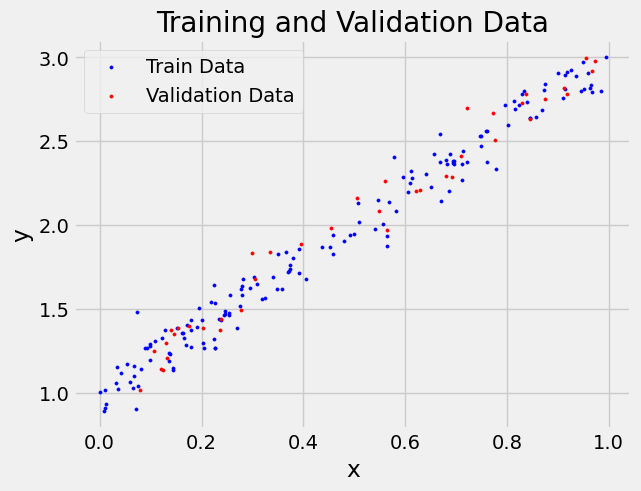

In [21]:
%run -i data/v2.py

# Model Configuration

In [39]:
%%writefile model/v4.py

# Learning rate
lr = 0.1

# Model
model = nn.Sequential(nn.Linear(1, 1)).to(device)

# SGD Optimizer
optimizer = optim.SGD(model.parameters(), lr=lr)

# MSE Loss
loss_fn = nn.MSELoss(reduction='mean')

# Train Step Function
train_step_fn = make_train_step_fn(model, loss_fn, optimizer)

# Validation Step Function
validation_step_fn = make_validation_step_fn(model, loss_fn)

writer = SummaryWriter('runs/linear_regression')

display(model.state_dict(), optimizer.state_dict())

USE_CHECKPOINT = False
start_epoch = 0
if USE_CHECKPOINT:
    checkpoint = torch.load('checkpoint.pth')
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    display('Loaded model from checkpoint')

Overwriting model/v4.py


In [40]:
%run -i model/v4.py

OrderedDict([('0.weight', tensor([[0.6688]], device='mps:0')),
             ('0.bias', tensor([0.6701], device='mps:0'))])

{'state': {},
 'param_groups': [{'lr': 0.1,
   'momentum': 0,
   'dampening': 0,
   'weight_decay': 0,
   'nesterov': False,
   'maximize': False,
   'foreach': None,
   'differentiable': False,
   'fused': None,
   'params': [0, 1]}]}

# Model Training

In [41]:
%%writefile train/v6.py

N_EPOCHS = 200
losses = []
validation_losses = []
for epoch in range(start_epoch, N_EPOCHS):
    loss = mini_batch(device, train_loader, train_step_fn)
    losses.append(loss)
    
    # Validation
    with torch.no_grad():
        validation_loss = mini_batch(device, validation_loader, validation_step_fn)
        validation_losses.append(validation_loss)

    # Records both losses
    writer.add_scalars(main_tag='loss', tag_scalar_dict={'training': loss, 'validation': validation_loss}, global_step=epoch)

    if epoch % 10 == 0:
        print(f'Epoch: {epoch}, Train Loss: {loss:.4f}, Validation Loss: {validation_loss:.4f}')

        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            'validation_loss': validation_loss
        }
        torch.save(checkpoint, 'checkpoint.pth')

writer.close()
display(model.state_dict(), optimizer.state_dict())

Overwriting train/v6.py


In [42]:
%run -i train/v6.py

Epoch: 0, Train Loss: 0.3090, Validation Loss: 0.1009
Epoch: 10, Train Loss: 0.0126, Validation Loss: 0.0161
Epoch: 20, Train Loss: 0.0093, Validation Loss: 0.0109
Epoch: 30, Train Loss: 0.0091, Validation Loss: 0.0115
Epoch: 40, Train Loss: 0.0091, Validation Loss: 0.0109
Epoch: 50, Train Loss: 0.0091, Validation Loss: 0.0107
Epoch: 60, Train Loss: 0.0090, Validation Loss: 0.0110
Epoch: 70, Train Loss: 0.0091, Validation Loss: 0.0105
Epoch: 80, Train Loss: 0.0092, Validation Loss: 0.0110
Epoch: 90, Train Loss: 0.0091, Validation Loss: 0.0110
Epoch: 100, Train Loss: 0.0092, Validation Loss: 0.0106
Epoch: 110, Train Loss: 0.0091, Validation Loss: 0.0106
Epoch: 120, Train Loss: 0.0092, Validation Loss: 0.0109
Epoch: 130, Train Loss: 0.0092, Validation Loss: 0.0105
Epoch: 140, Train Loss: 0.0090, Validation Loss: 0.0101
Epoch: 150, Train Loss: 0.0092, Validation Loss: 0.0100
Epoch: 160, Train Loss: 0.0091, Validation Loss: 0.0105
Epoch: 170, Train Loss: 0.0093, Validation Loss: 0.0105
Epo

OrderedDict([('0.weight', tensor([[1.9950]], device='mps:0')),
             ('0.bias', tensor([1.0000], device='mps:0'))])

{'state': {},
 'param_groups': [{'lr': 0.1,
   'momentum': 0,
   'dampening': 0,
   'weight_decay': 0,
   'nesterov': False,
   'maximize': False,
   'foreach': None,
   'differentiable': False,
   'fused': None,
   'params': [0, 1]}]}

<Figure size 640x480 with 0 Axes>

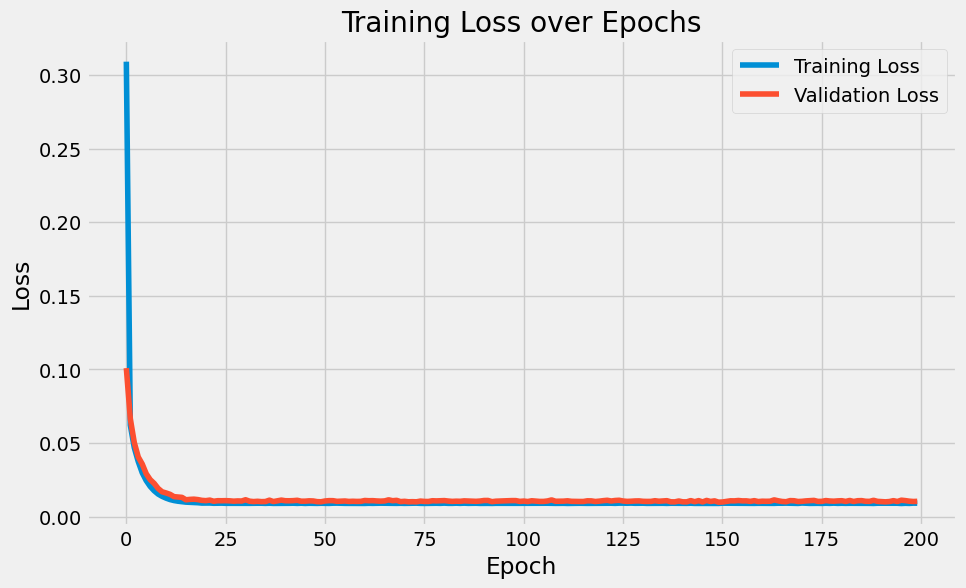

In [43]:
plt.figure(figsize=(10, 6))
plt.plot(losses, label='Training Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

# Inference

In [45]:
checkpoint = torch.load('checkpoint.pth')
model.load_state_dict(checkpoint['model_state_dict'])
display(model.state_dict())
new_inputs = torch.tensor([[0.2], [0.34], [0.57]])
# Inference mode
model.eval()
# Forward pass
model(new_inputs.to(device))


/var/folders/0t/6dmmd17n7vq4kynzhfvvv6wc0000gn/T/ipykernel_1920/2530560291.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('checkpoint.pth')


OrderedDict([('0.weight', tensor([[1.9963]], device='mps:0')),
             ('0.bias', tensor([1.0035], device='mps:0'))])

tensor([[1.4028],
        [1.6823],
        [2.1414]], device='mps:0', grad_fn=<LinearBackward0>)